In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis [in this article](https://fivethirtyeight.com/features/fandango-movies-ratings/) — a great piece of data journalism that's totally worth reading.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.



![tags_ds](https://linkpicture.com/q/Screen-Shot-2020-09-16-at-9.41.56-PM.png)
  source: [Fandango](https://www.fandango.com/avengers-age-of-ultron-2015-157897/movie-overview)

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

- The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

![tag_ds](https://fivethirtyeight.com/wp-content/uploads/2015/10/hickey-datalab-fandango-1-just_fandango.png?w=1150)
source: [FiveThirtyEight](https://fivethirtyeight.com/features/fandango-movies-ratings/)

The two distributions above are displayed using a simple line plot, which is also a valid way to show the shape of a distribution. The variable being examined is movie rating, and for each unique rating we can see its relative frequency (percentage) on the y-axis of the graph. When an analysis report is intended for large audiences, relative frequencies (especially percentages) are preferred over absolute frequencies.

Both distributions above are strongly left skewed, suggesting that movie ratings on Fandango are generally high or very high. We can see there's no rating under 2 stars in the sample Hickey analyzed. The distribution of displayed ratings is clearly shifted to the right compared to the actual rating distribution, suggesting strongly that Fandango inflates the ratings under the hood.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

# Understanding the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

fandango = pd.read_csv('fandango_score_comparison.csv')
rating_16_17 = pd.read_csv('movie_ratings_16_17.csv')

print(fandango.head())
print(rating_16_17.head())

                             FILM  RottenTomatoes  RottenTomatoes_User  \
0  Avengers: Age of Ultron (2015)              74                   86   
1               Cinderella (2015)              85                   80   
2                  Ant-Man (2015)              80                   90   
3          Do You Believe? (2015)              18                   84   
4   Hot Tub Time Machine 2 (2015)              14                   28   

   Metacritic  Metacritic_User  IMDB  Fandango_Stars  Fandango_Ratingvalue  \
0          66              7.1   7.8             5.0                   4.5   
1          67              7.5   7.1             5.0                   4.5   
2          64              8.1   7.8             5.0                   4.5   
3          22              4.7   5.4             5.0                   4.5   
4          29              3.4   5.1             3.5                   3.0   

   RT_norm  RT_user_norm         ...           IMDB_norm  RT_norm_round  \
0     3.70 

For the Fandago data before Hickey's analysis, we only focus on Fandango columns and for Hickey's data, we will only keep the 'movie', 'year', 'fandango' columns

In [2]:
fandango_before = fandango[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes',
                           'Fandango_Difference']].copy()

fandango_after = rating_16_17[['movie', 'year','fandango']].copy()

fandango_before.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [3]:
fandango_after.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. The population of interest for our analysis is made of all the movie ratings stored on Fandango's website, regardless of the releasing year.

Because we want to find out whether the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — previous and after Hickey's analysis — so we can compare the two states.

The data we're working with was sampled at the moments we want: one sample was taken previous to the analysis, and the other after the analysis. We want to describe the population, so we need to make sure that the samples are representative, otherwise we should expect a large sampling error and, ultimately, wrong conclusions.

From Hickey's article and from the README.md of [the data set's repository](https://github.com/fivethirtyeight/data/tree/master/fandango), we can see that he used the following sampling criteria:

The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
The movie must have had tickets on sale in 2015.
The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the README.md of the data set's repository):

The movie must have been released in 2016 or later.
The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).
This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.

# Changing the Goal of our Analysis

At this point, we can either collect new data or change our the goal of our analysis. We choose the latter and place some limitations on our initial goal.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

# Isolating the Samples We Need

With the new goal, we now have two populations that we want to describe and compare with each other:

- All Fandango's ratings for popular movies released in 2015.
- All Fandango's ratings for popular movies released in 2016.

The term "popular" is vague and we need to define it with precision before continuing. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as "popular" only if it has 30 fan ratings or more on Fandango's website.

In [4]:
fandango_before.sample(10, random_state=1)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
98,Get Hard (2015),4.0,3.9,5933,0.1
66,The Gift (2015),4.0,3.7,2680,0.3
53,Hot Pursuit (2015),4.0,3.7,2618,0.3
75,San Andreas (2015),4.5,4.3,9749,0.2
121,The Stanford Prison Experiment (2015),4.0,3.9,51,0.1
74,The Hobbit: The Battle of the Five Armies (2014),4.5,4.3,15337,0.2
119,Phoenix (2015),3.5,3.4,70,0.1
128,Mission: Impossible â€“ Rogue Nation (2015),4.5,4.4,8357,0.1
44,Kingsman: The Secret Service (2015),4.5,4.2,15205,0.3
58,Seventh Son (2015),3.5,3.2,1213,0.3


After doing research on the Fandango website, we can assure that 90% of these movies are popular (more than 30 fan ratings) - so this sample can be representative

Some movies are not released in 2015 and 2016, we need to isolate only the sample points that belong to our populations of interest

In [5]:
fandango_before['YEAR'] = fandango['FILM'].str[-5:-1]
fandango_before.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,YEAR
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [6]:
fandango_before['YEAR'].value_counts()

2015    129
2014     17
Name: YEAR, dtype: int64

In [7]:
fandango_before = fandango_before[fandango_before['YEAR']=='2015'].copy()
fandango_before['YEAR'].value_counts()

2015    129
Name: YEAR, dtype: int64

In [8]:
fandango_after = fandango_after[fandango_after['year']==2016].copy()
print(fandango_after['year'].value_counts())
fandango_after.head(3)

2016    191
Name: year, dtype: int64


,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


# Comparing Distribution Shapes for 2015 and 2016

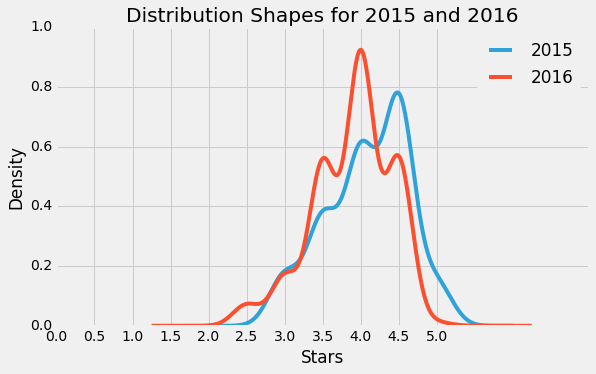

In [9]:
from numpy import arange

plt.style.use('fivethirtyeight')
fandango_before['Fandango_Stars'].plot.kde(label='2015', legend=True,figsize=(8.5,5))
fandango_after['fandango'].plot.kde(label='2016',legend=True)

plt.xticks(arange(0,5.1,.5))
plt.xlabel('Stars')
plt.legend()

plt.title('Distribution Shapes for 2015 and 2016')


Two aspects are striking on the figure above:

- Both distributions are strongly left skewed.
- The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.
The left skew suggests that movies on Fandango are given mostly high and very high fan ratings. Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious. It'd be really interesting to investigate this further — ideally in a separate project, since this is quite irrelevant for the current goal of our analysis.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015.

# Comparing Relative Frequencies

In [12]:
print('2015' + '\n' + '-'*16) #to make it better for code reading

fandango_before['Fandango_Stars'].value_counts(normalize=True).sort_index()*100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [13]:
print('2016' + '\n' + '-'*16)
fandango_after['fandango'].value_counts(normalize=True).sort_index()*100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, very high ratings (4.5 & 5.0) has significant lower advantages compared to 2015. In 2016, under 1% of the movies were rated 5 stars, however, in 2015, that number was almost 7%.  Rating of 4.5 was also more popular in 2015 compraed to 2016.

The minimum rating in 2016 is also lower than its of 2015 (2.5 in 2016 & 3.0 in 2015). This is a clear difference between two distributions

We also notice that the ratings from 3.5 to 4 stars are much higher in 2016 compared to 2015. We couldn't see this trend in kernel desity plot.


# Determining the Direction of the Change

In [20]:
mean_2016 = fandango_after['fandango'].mean()
mean_2015 = fandango_before['Fandango_Stars'].mean()

mode_2016 = fandango_after['fandango'].mode()[0]
mode_2015 = fandango_before['Fandango_Stars'].mode()[0]

median_2016 = fandango_after['fandango'].median()
median_2015 = fandango_before['Fandango_Stars'].median()

summary = pd.DataFrame()
summary['Year_2015'] = [mean_2015, mode_2015, median_2015]
summary['Year_2016'] = [mean_2016, mode_2016, median_2016]
summary.index = ['mean', 'mode', 'median']

summary

,Year_2015,Year_2016
mean,4.085271,3.887435
mode,4.500000,4.000000
median,4.000000,4.000000


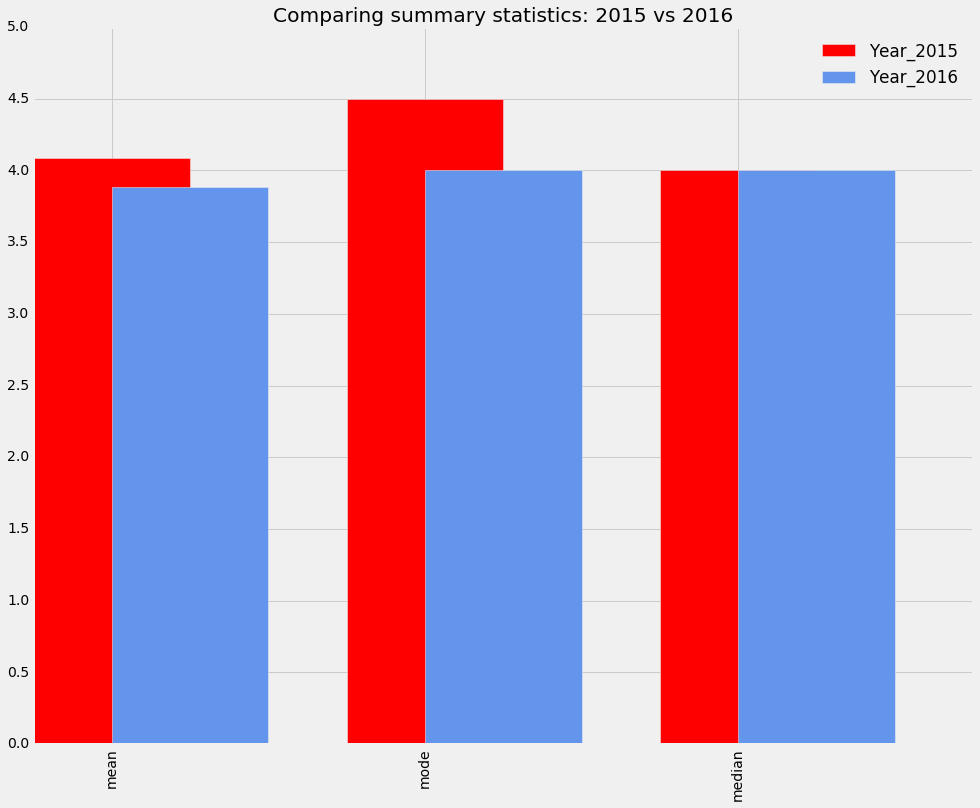

In [34]:
summary['Year_2015'].plot.bar(align='center', color='#FF0000', figsize=(15,12))
summary['Year_2016'].plot.bar(align='edge', color='#6495ED')

plt.title('Comparing summary statistics: 2015 vs 2016')
plt.legend()
plt.yticks(arange(0,5.1,.5))

plt.show()

The mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

In [36]:
(summary.loc['mean'][0] - summary.loc['mean'][1]) / summary.loc['mean'][0]

0.04842683568951993

While the median is the same for both distributions, the mode is lower in 2016 by 0.5. Coupled with what we saw for the mean, the direction of the change we saw on the kernel density plot is confirmed: on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.

# Conclusion

Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.